In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [2]:
def normalize(img):
    height = img.shape[0]
    length = img.shape[1]
    channels = img.shape[2]
    
    res = np.array([ [ [np.uint8(0)] * channels for i in range(length)] for j in range(height)])
    for c in range(img.shape[2]):
        max = 0
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if max < img[i][j][c]:
                    max = img[i][j][c]
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                res[i][j][c] = np.uint8(round(img[i][j][c] / max * 255))
                
    return res

def detector_max(himg):
    height = himg.shape[0]
    length = himg.shape[1]
    channels = himg.shape[2]
    max = 0
    a = 0
    maxx = 0
    maxy = 0
    for i in range(height):
        for j in range(length):
            a = 0
            for c in range(channels):
                a += himg[i][j][c]
            if (a > max):
                max = a
                maxx = i
                maxy= j
        #print(">>", i, j, maxx, maxy)
    return maxx, maxy

def detector_min(himg):
    height = himg.shape[0]
    length = himg.shape[1]
    channels = himg.shape[2]
    min = 255 * 3
    a = 0
    minx = 0
    miny = 0
    for i in range(height):
        for j in range(length):
            a = 0
            for c in range(channels):
                a += himg[i][j][c]
            if (a < min):
                min = a
                minx = i
                miny= j
        #print(i, j)
    return minx, miny

In [3]:
def FHT_vert_r(img):
    height = img.shape[0]
    length = img.shape[1]
    channels = img.shape[2]
    
    hough_Img = np.array([ [ [0] * channels for i in range(length)] for j in range(height)])
    if(length == 1):
        return img
    left = []
    right = []
    for i in range(height):
        left.append(img[i][:(length // 2)])
        right.append(img[i][(length // 2):])
    left = FHT_vert_r(np.array(left))
    right = FHT_vert_r(np.array(right))
    for ch in range(channels):
        for i in range(0, length, 2):
            shift = i // 2
            for j in range(height):
                index = (j + shift) % height
                hough_Img[j][i][ch] = int(left[j][i // 2][ch]) + int(right[index][i // 2][ch])
                index = (j + shift + 1) % height
                hough_Img[j][i + 1][ch] = int(left[j][i // 2][ch]) + int(right[index][i // 2][ch])
    return hough_Img



In [4]:

def reflect_y(img):
    img = copy.deepcopy(img)
    for i in range(img.shape[0] // 2):
        tmp = copy.deepcopy(img[i])
        img[i] = img[img.shape[0] - i - 1]
        img[img.shape[0] - i - 1] = tmp
    return img

def reflect_x(img):
    img = copy.deepcopy(img)
    for i in range(img.shape[0]):
        img[i] = reflect_y(img[i])
    return img


In [5]:
def FHT(img, direction='all'):
    height = img.shape[0]
    length = img.shape[1]
    channels = img.shape[2]
    
    if(direction == 'all' or direction == 'vr'):
        hough_vr = FHT_vert_r(img)
        ret = hough_vr
        
    if(direction == 'all' or direction == 'vl'):
        hough_vl = reflect_x(reflect_y(FHT_vert_r(reflect_y(img))))
        #hough_vl = (FHT_vert_r(reflect_x(img)))
        ret = hough_vl
        
    if(direction == 'all' or direction == 'hd'):
        #hough_hd = reflect_y(np.transpose((FHT_vert_r(np.transpose(reflect_y(img) ,(1, 0, 2)))), (1, 0, 2)))
        #hough_hd = np.transpose(hough_hd, (1, 0, 2))
        #hough_hd = ((FHT_vert_r(np.transpose(reflect_y(img) ,(1, 0, 2)))) )
        hough_hd = np.transpose(reflect_y(FHT_vert_r(reflect_y(np.transpose(img ,(1, 0, 2))))), (1, 0, 2))
        
        #hough_hd = reflect_y(hough_hd)
        #hough_hd = reflect_x(hough_hd)
        
        #поворот на 90 против ч
        hough_hd = np.transpose(hough_hd, (1, 0, 2))
        hough_hd = reflect_y(hough_hd)
        
        ret = hough_hd
        
    if(direction == 'all' or direction == 'hu'):
        hough_hu = np.transpose(FHT_vert_r(np.transpose(img, (1, 0, 2))), (1, 0, 2))
        hough_hu = reflect_y(hough_hu) #????
        #поворот на 90 против ч
        hough_hu = np.transpose(hough_hu, (1, 0, 2))
        hough_hu = reflect_y(hough_hu)
        #hough_hu = FHT_vert_r(np.transpose(img, (1, 0, 2)))
        #hough_hu = reflect_x(hough_hu)
        ret = hough_hu
        
    if(direction == 'all'):
        hough_all = np.array([ [ [0] * channels for i in range(4 * length)] for j in range(height)])
        #ough_all[:height] = hough_vr
        #ough_all[height:(2 * height)] = hough_vl
        #ough_all[(2 * height):(3 * height)] = hough_hd
        #ough_all[(3 * height):(4 * height)] = hough_hu
        
        for i in range(height):
            hough_all[i][:length] = (hough_vl[i])
            hough_all[i][length:(2 * length)] = hough_vr[i]
            hough_all[i][(2 * length):(3 * length)] = hough_hu[i]
            hough_all[i][(3 * length):(4 * length)] = hough_hd[i]
        """
        hough_all = np.array([ [ [0] * channels for i in range(2 * length)] for j in range(2 * height)])
        #ough_all[:height] = hough_vr
        for i in range(height):
            hough_all[i][:length] = hough_hu[i]
            hough_all[i][length:] = hough_hd[i]
            hough_all[i + height][:length] = hough_vl[i]
            hough_all[i + height][length:] = hough_vr[i]
        """
        ret = hough_all
        
    return normalize(ret)

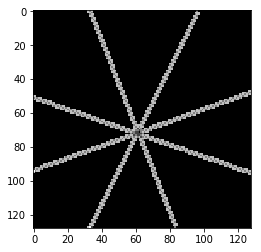

In [112]:
img1 = cv.imread("./img/line64x64_horiz_r.png")
img2 = cv.imread("./img/line64x64_horiz_l.png")
img3 = cv.imread("./img/line64x64_l.png")
img4 = cv.imread("./img/line64x64.png")
#img1 = img2 = img3 = img4 = cv.imread("./img/qqq.png")
window = 1
img=img4
#img = cv.imread("./img/123.png")
#img = cv.imread("./img/4x4hu.png")
#img = cv.imread("./img/diag_bl2.png")
#img = cv.imread("./img/point64x64.png")
img = cv.imread("./img/bundle.png")
#img = cv.imread("./img/qqq.png")
#img = normalize(cv.blur(normalize(cv.Laplacian(img,cv.CV_64F)),(window ,window )))
img = normalize(cv.Laplacian(img, cv.CV_64F))

#print(type(img[47][17][0]))
plt.imshow(img)


True

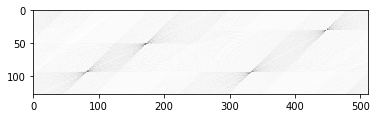

In [105]:
himg = FHT(img, direction ='all')
plt.imshow(himg)
cv.imwrite("res.png", himg)
#himg[4][277]

In [113]:
point1 = detector_max(himg)
print(point1[0], point1[1])


11 110


In [114]:
def rd(n):
    if((n - int(n)) >= 0.5):
        return (int(n)+1)
    else:
        return int(n)

from math import log2
"""    
def draw_horiz_up(img, s, t, color):
    p = int(log2(img.shape[0]))
    t_bytes = np.zeros(p, dtype=int)
    for i in range(p):
        t_bytes[i] = t % 2
        t = t // 2
    for x in range(img.shape[0]):
        y = 0
        for k in range(len(t_bytes)):
            y += t_bytes[k] * rd(2 ** k * x/ (img.shape[0] - 1))
        y += s
        y = y % img.shape[0]
        img[x][y] = np.uint8(color)
    return img

def draw_horiz_dwn(img, s, t, color):
    p = int(log2(img.shape[0]))
    t_bytes = np.zeros(p, dtype=int)
    for i in range(p):
        t_bytes[i] = t % 2
        t = t // 2
    for x in range(img.shape[0]):
        y = 0
        for k in range(len(t_bytes)):
            y -= t_bytes[k] * rd(2 ** k * x/ (img.shape[0] - 1))
        y += s
        y = y % img.shape[0]
        img[x][y] = np.uint8(color)
    return img
    

"""
def draw_vert_r(img, s, t, color):
    p = int(log2(img.shape[0]))
    t_bytes = np.zeros(p, dtype=int)
    for i in range(p):
        t_bytes[i] = t % 2
        t = t // 2
    for y in range(img.shape[0]):
        x = 0
        for k in range(len(t_bytes)):
            x += t_bytes[k] * rd(2 ** k * y/ (img.shape[0] - 1))
        x += s
        x = x % img.shape[0]
        img[x][y] = np.uint8(color)
    return img

def draw_vert_l(img, s, t, color):
    p = int(log2(img.shape[0]))
    t_bytes = np.zeros(p, dtype=int)
    for i in range(p):
        t_bytes[i] = t % 2
        t = t // 2
    for y in range(img.shape[0]):
        x = 0
        for k in range(len(t_bytes)):
            x -= t_bytes[k] * rd(2 ** k * y/ (img.shape[0] - 1))
        x += s
        x = x % img.shape[0]
        img[x][y] = np.uint8(color)
    return img

def drawline(img, point, color):
    length = img.shape[1]
    height = img.shape[0]
    canvas = copy.deepcopy(img)
    if(point[1] in range(length)):
        #canvas = draw_vert_l(canvas, point[0], height - 1 - point[1], color)
        #canvas = reflect_y(canvas)
        #canvas = np.transpose(canvas, (1, 0, 2))
        #canvas = reflect_y(canvas)
        #canvas = np.transpose(canvas, (1, 0, 2))
        canvas = reflect_y(canvas)
        
        canvas = draw_vert_r(canvas, height - point[0] - 1, height - point[1], color)
        plt.imshow(canvas)
        canvas = reflect_y(canvas)
        #canvas = np.transpose(canvas, (1, 0, 2))
        #canvas = reflect_y(canvas)
        #canvas = np.transpose(canvas, (1, 0, 2))
    if(point[1] in range(length, 2 * length)):
        canvas = draw_vert_r(canvas, point[0], point[1], color)
    if(point[1] in range(length * 2, 3 * length)):
        #canvas = draw_horiz_up(canvas, height - (point[1] - 2 * length), point[0], color)  
        canvas = np.transpose(canvas, (1, 0, 2))
        canvas = reflect_y(canvas)
        #canvas = draw_vert_l(canvas,  point[0], height - point[1] - 1, color)
        
        canvas = reflect_y(canvas)
        canvas = draw_vert_r(canvas, height - point[0] - 1, height - point[1] - 1, color)
        #plt.imshow(canvas)
        canvas = reflect_y(canvas)
        
        canvas = reflect_y(canvas)
        canvas = np.transpose(canvas, (1, 0, 2))
    if(point[1] in range(length * 3, 4 * length)):
        canvas = np.transpose(canvas, (1, 0, 2))
        canvas = reflect_y(canvas)
        canvas = draw_vert_r(canvas, point[0], point[1], color)
        plt.imshow(canvas)
        canvas = reflect_y(canvas)
        canvas = np.transpose(canvas, (1, 0, 2))
    return canvas



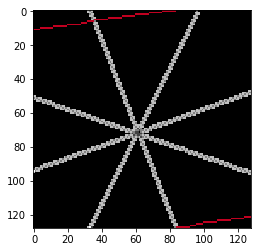

In [115]:
resimg = drawline(img, point1, (193, 0, 32))
plt.imshow(resimg)

3 102


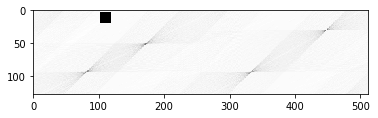

In [116]:
def supp_point(img, x, y, sq_size = 1, color = (0, 0, 0)):
    img = copy.deepcopy(img)
    for i in range (x - sq_size, x + sq_size + 1, 1):
        for j in range (y - sq_size, y + sq_size + 1, 1):
            if(i >= 0 and i <= img.shape[0] and j >= 0 and j <= img.shape[1]):
                img[i][j] = color
    return img

himg_supp = supp_point(himg, point1[0], point1[1], sq_size = 8)
plt.imshow(himg_supp)
    
point2 = detector_min(himg_supp)
print(point2[0], point2[1])



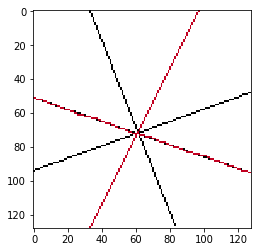

In [111]:
resimg = drawline(resimg, point2, (193, 0, 32))
plt.imshow(resimg)

119 359


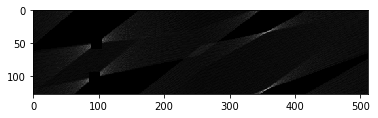

In [43]:
himg_supp = supp_point(himg_supp, point2[0], point2[1], sq_size = 8)
plt.imshow(himg_supp)
 
point3 = detector_max(himg_supp)
print(point3[0], point3[1])

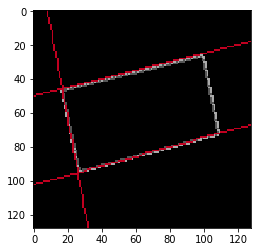

In [44]:
resimg = drawline(resimg, point3, (193, 0, 32))
plt.imshow(resimg)

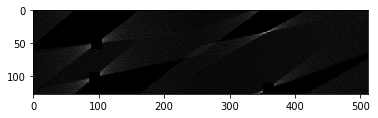

In [45]:
himg_supp = supp_point(himg_supp, point3[0], point3[1], sq_size = 8)
plt.imshow(himg_supp)

33 357


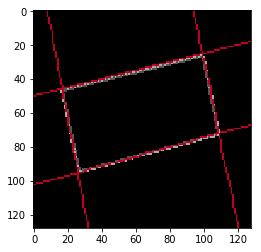

In [46]:
point4 = detector_max(himg_supp)
print(point4[0], point4[1])

resimg = drawline(resimg, point4, (193, 0, 32))
plt.imshow(resimg)

In [17]:
point2 = detector_max(himg)
print(point2[0], point2[1])

50 96


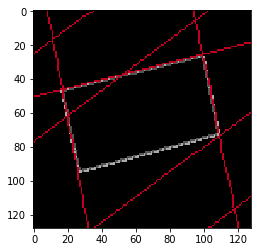

In [18]:
resimg = draw_vert_l(resimg, point2[0], 127 - point2[1], (193, 0, 32))
plt.imshow(resimg)

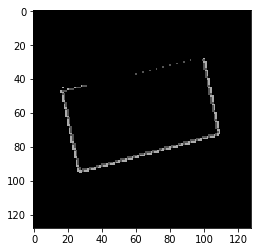

In [19]:
img = draw_vert_l(img, point2[0], 127 - point2[1], (0, 0, 0))
img = draw_vert_l(img, point2[0], 127 - point2[1] + 1, (0, 0, 0))
img = draw_vert_l(img, point2[0], 127 - point2[1] - 1, (0, 0, 0))
img = draw_vert_l(img, point2[0], 127 - point2[1] + 2, (0, 0, 0))
img = draw_vert_l(img, point2[0], 127 - point2[1] - 2, (0, 0, 0))
plt.imshow(img)

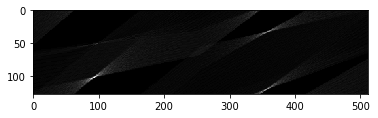

In [20]:
himg = FHT(img, direction ='all')
plt.imshow(himg)

In [21]:
point3 = detector_max(himg)
print(point3[0], point3[1])

102 93
